# Übung 7 Lineare Regression - Rainier Robles & Valentin Wolf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_table('spam.data', delim_whitespace=True,header=None)

from sklearn.utils import shuffle

N,features = data.shape

#Normalize data but not the label
for i in range(features-1):
    data[i] = (data[i] - data[i].mean()) / np.sqrt(data[i].var())
    data[i] = data[i] #
    
#data[data[features-1] == 0].loc[:,features-1] = -1
#data[features == 1] = 1

data = shuffle(data,random_state=1338)
split = 0.2
y_train = data.iloc[int(split*N):, -1].as_matrix()
X_train = data.iloc[int(split*N):, :-1].as_matrix()

y_test = data.iloc[:int(split*N), -1].as_matrix()
X_test = data.iloc[:int(split*N), :-1].as_matrix()

y_test[y_test == 0] = -1
y_train[y_train == 0] = -1

In [3]:
class Classifier():
    def error_rate(self,truth, pred):
        """gets two vectors, returns (wrongly classified / total)"""
        return 1 - self.accuracy(truth, pred)
    
    def accuracy(self,truth,pred):
        return np.mean(truth == pred)

In [4]:
class LinearRegression(Classifier):
    def train(self,X,y,iterations = 1000, learning_rate = 0.05):
        self.classes = np.unique(y)
        assert(len(np.unique(y)) == 2)
        
        y[y == self.classes[0]] = -1
        y[y == self.classes[1]] = 1
        
        X = self._appendOnes(X)

        N,features = X.shape

        try:
            self.beta
        except AttributeError:
            self.beta = (np.random.rand(1,features)*2)-1
        
        #Gradient ascend
        for i in range(iterations):
            self.beta += learning_rate * self.gradient(X,y)
        
        return self.beta
        
    def _appendOnes(self,X):
        datapoints,dims = X.shape
        return np.concatenate((np.ones((datapoints,1)),X),axis=1)
            
    def gradient(self,X,y):
        grad = np.zeros(self.beta.shape)
        for i in self.classes:                
            yi = y[y == i]
            Xi = X[y == i]
            a = yi.reshape(-1,1)*Xi
            b = (1-self.cond_prob(Xi,yi))
            grad += a.T.dot(b.T).T
        return grad
    
    def cond_prob(self,X,y):
        return 1 / (1+np.exp((-y)*np.dot(self.beta,X.T)))
                             
    def predict(self,X):
        X = self._appendOnes(X)
        pred = np.argmax([self.cond_prob(X,-1),self.cond_prob(X,1)], axis=0)
        pred[pred==0] = self.classes[0]
        pred[pred==0] = self.classes[1]
        return pred#(np.argmax([self.cond_prob(X,-1),self.cond_prob(X,1)], axis=0))

# Aufgabe 1

In [5]:
iterations = 1000
stepsize = 1
amountCls = 5

loops = iterations//stepsize
classifiers = []
accTe = []
accTr = []
acc = []
for i in range(amountCls):
    classifiers.append(LinearRegression())
    accTr.append([])
    accTe.append([])
    acc.append([])
for j in range(loops):
    #print("Iteration:",j*stepsize)
    for i in range(amountCls):
        classifiers[i].train(X_train,y_train,iterations = stepsize, learning_rate = 1/10**(i+2))
        acc_train = classifiers[i].accuracy(y_train,classifiers[i].predict(X_train))
        acc_test = classifiers[i].accuracy(y_test,classifiers[i].predict(X_test))

        acc[i].append((acc_test,acc_train))
        
        #print("TrainErr", acc_train,"TestErr", acc_test)

In [6]:
from sklearn.metrics import confusion_matrix
i=0
for cls in classifiers:
    pred = classifiers[i].predict(X_test)
    trainacc = cls.accuracy(y_train,cls.predict(X_train))
    testacc = cls.accuracy(y_test,cls.predict(X_test))
    cm= confusion_matrix(y_test,cls.predict(X_test).reshape(-1,))
    
    print("Learning Rate", 1/10**(i+3), "Train/Test accuracy: ", round(trainacc,4),"/",round(testacc,4))
    i+=1

    print(cm)

Learning Rate 0.001 Train/Test accuracy:  0.8783 / 0.8783
[[518  20]
 [ 92 290]]
Learning Rate 0.0001 Train/Test accuracy:  0.9337 / 0.9196
[[511  27]
 [ 47 335]]
Learning Rate 1e-05 Train/Test accuracy:  0.9291 / 0.9207
[[512  26]
 [ 47 335]]
Learning Rate 1e-06 Train/Test accuracy:  0.915 / 0.9065
[[508  30]
 [ 56 326]]
Learning Rate 1e-07 Train/Test accuracy:  0.7414 / 0.7467
[[392 146]
 [ 87 295]]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


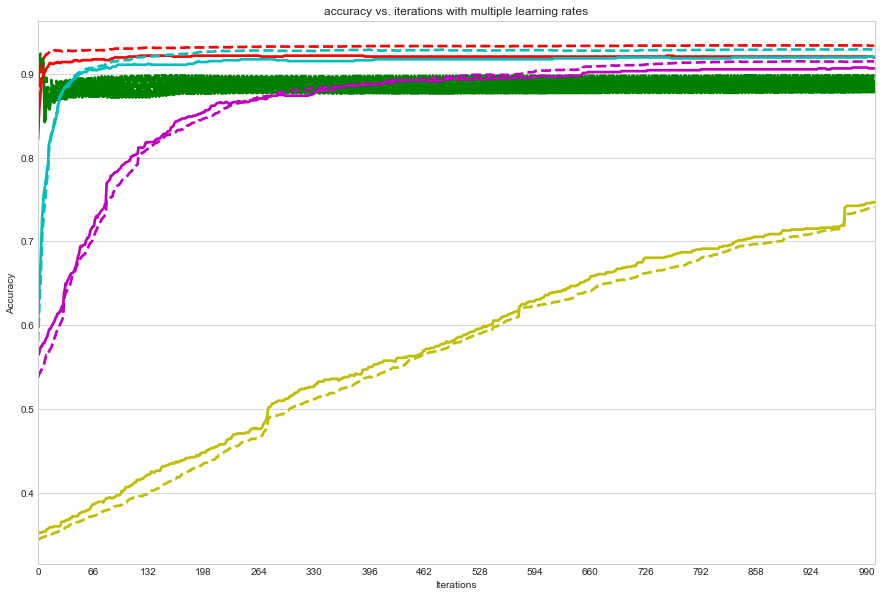

In [7]:
sns.set_style('whitegrid')
test = accTe[3]
colors = ['g', 'r', 'c', 'm', 'y', 'b' ]

plt.figure(figsize=(15, 10))

for i in range(amountCls):
    y_te,y_tr = zip(*acc[i])
    ax = sns.pointplot(list(range(0,iterations,stepsize)),y_tr, label='test', linestyles='--', markers='',color=colors[i], )
    ax = sns.pointplot(list(range(0,iterations,stepsize)),y_te, markers='',color=colors[i], label='test')


#add lables to axes
plt.title('accuracy vs. iterations with multiple learning rates')
ax.set(xlabel='Iterations', ylabel='Accuracy')

#fix x-axis tick frequency
import matplotlib.ticker as ticker
ax.xaxis.set_major_locator(ticker.MultipleLocator(iterations//15))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.legend()
plt.show()

Wie könnte man das Modell anpassen, um eine der Klassen zu bevorzugen?

Indem man die Gradienten der einer Klasse stärker Gewichtet / den der anderen Klasse weniger gewichtet. Z.b. so:

In [8]:
def weighted_gradient(self,X,y):
    grad = np.zeros(self.beta.shape)
    for i in self.classes:

        if i == 1:
            weight = 2
        else:
            weight = 0.1

        yi = y[y == i]
        Xi = X[y == i]
        a = yi.reshape(-1,1)*Xi
        b = (1-self.cond_prob(Xi,yi))
        grad += weight * a.T.dot(b.T).T
    return grad

# Aufgabe 2

In [9]:
X = np.asarray([[0,0],[0,1],[1,0],[1,1]])
y_and = np.asarray([-1,-1,-1,1])
y_or = np.asarray([-1,1,1,1])
y_xor = np.asarray([-1,1,1,-1])

In [10]:
loand = LinearRegression()
loand.train(X,y_and,iterations = 1000, learning_rate = 0.05)
loand.predict(X)

array([[-1, -1, -1,  1]])

In [11]:
lor = LinearRegression()
lor.train(X,y_or)
lor.predict(X)

array([[-1,  1,  1,  1]])

In [12]:
lxor = LinearRegression()
lxor.train(X,y_xor)
lxor.predict(X)

array([[-1, -1, -1,  1]])

__Fazit:__ Logistische Regression kann das logisch OR lernen, XOR und AND jedoch nicht.